In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### Import libraries as needed

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy

### Define helper functions

In [ ]:
###########################################################################################

# Function to plot the training and validation accuracy and loss --------------------------
def plot_history(history):
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot([acc.cpu().numpy() for acc in history['train_acc']], label="train accuracy")
    axs[0].plot([acc.cpu().numpy() for acc in history['val_acc']], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history['train_loss'], label="train error")
    axs[1].plot(history['val_loss'], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

###########################################################################################

# Function to visualize some images before you train --------------------------------------
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

############################################################################################

# Function to visualize sample count before split ------------------------------------------
def plot_class_distribution(counts, title):
    labels = [f"{idx}: {idx_to_class[idx]}" for idx in counts.keys()]
    values = list(counts.values())

    plt.figure(figsize=(10,5))
    plt.bar(labels, values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

############################################################################################

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual Label');
    plt.xlabel('Predicted Label');
    plt.title('Confusion Matrix', size=15);
    plt.show()

############################################################################################

# Function for classification report for perfomance metrics
from sklearn import preprocessing
def calculate_metrics(y_true, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_true)
    class_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_true, y_pred, target_names=class_names))

############################################################################################


### Define function to **train** the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
                print("training phase")
            else:
                model.eval()   # Set model to evaluate mode
                print("eval phase")

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # print("end inner loop")

            if phase == 'Train':
                scheduler.step()

            # epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'/content/drive/MyDrive/Final Project/model_weights/bestmodel_6layer_CNN.pth')

            # Save the loss and accuracy in history
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Load data, setup dataloaders, and visualize sample counts

In [ ]:
# Define your transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal mirroring
    transforms.RandomRotation(10),  # ±10 degree rotations
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
])

# Define your transformations for the validation and test sets
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
])

train_dir = '/content/drive/MyDrive/Final Project/train'
test_dir = '/content/drive/MyDrive/Final Project/test'

# Load the datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

In [ ]:
print(train_data.classes)

['angry', 'fear', 'happy', 'sad', 'surprise']


In [ ]:
# Get the class names
class_names_train = test_data.classes
class_names_test = test_data.classes

# Create a dictionary mapping indices to class names
idx_to_class_train = {i: class_name for i, class_name in enumerate(class_names_train)}
idx_to_class_test = {i: class_name for i, class_name in enumerate(class_names_test)}

# Count labels in the original dataset for train and test
train_counts = Counter(train_data.targets)
test_counts = Counter(test_data.targets)

# Adjust the counts to exclude 'happy_2'
train_counts = {i: count for i, count in train_counts.items() if i in idx_to_class_train.keys()}

# Print the counts
print("Train Counts:", {idx_to_class_train[i]: count for i, count in train_counts.items()})
print("Test Counts:", {idx_to_class_test[i]: count for i, count in test_counts.items()})

Train Counts: {'angry': 3995, 'fear': 4097, 'happy': 7215, 'sad': 4830, 'surprise': 3171}
Test Counts: {'angry': 958, 'fear': 1024, 'happy': 1774, 'sad': 1247, 'surprise': 831}


In [ ]:
# Get the indices of the samples in the validation and test sets
test_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' in img_path]
valid_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' not in img_path]

# Create subset datasets
validation_data = torch.utils.data.Subset(test_data, valid_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

# Create data loaders
batch_size = 32
num_workers = 2
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders = {
    'Train': train_loader,
    'Validation': validation_loader,
    'Test': test_loader
}

In [ ]:
print("Length of Train Loader: ", len(dataloaders['Train']))
print("Length of Validation Loader: ", len(dataloaders['Validation']))
print("Total count of samples in train set:", len(train_data))
print("Total count of samples in validation set:", len(validation_data))
print("Total count of samples in test set:", len(test_data))

Length of Train Loader:  729
Length of Validation Loader:  92
Total count of samples in train set: 23308
Total count of samples in validation set: 2926
Total count of samples in test set: 2908


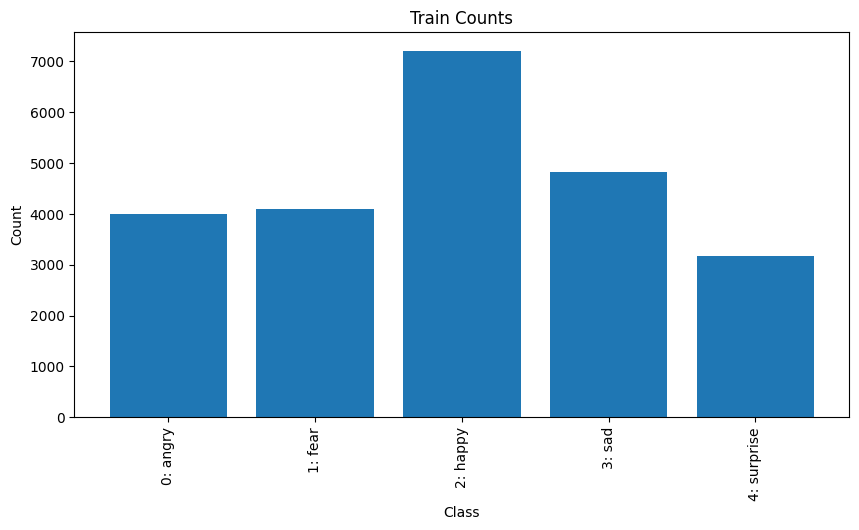

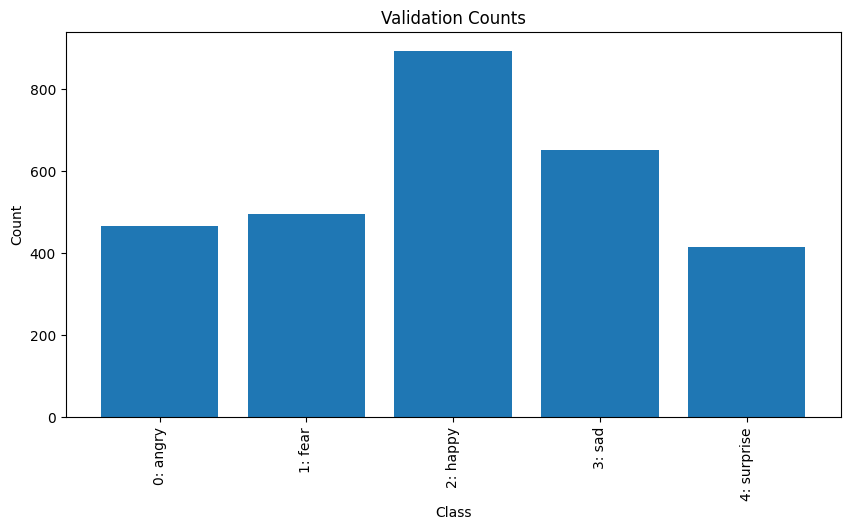

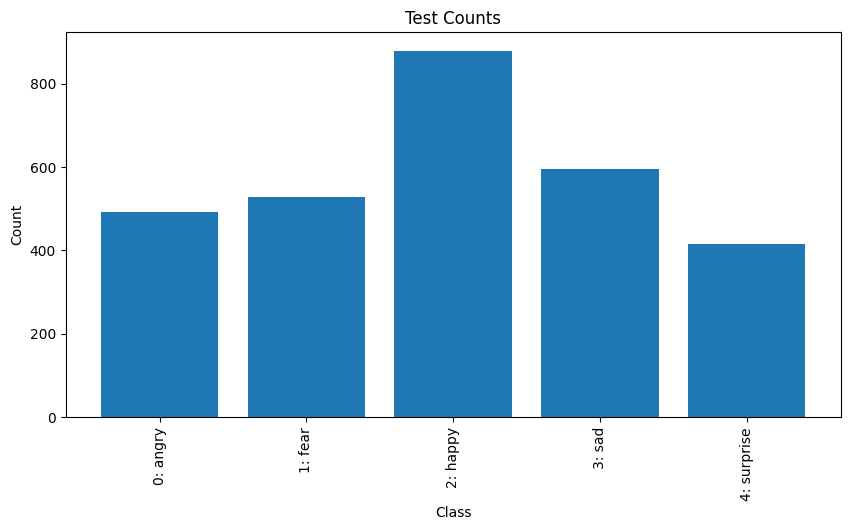

In [ ]:
# Get the class names
class_names = train_data.classes

# Create a dictionary mapping indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Count labels in the original dataset for train
original_counts = Counter(train_data.targets)

# Count labels in the subsets
valid_counts = Counter(test_data.dataset.targets[i] for i in valid_indices)
test_counts = Counter(test_data.dataset.targets[i] for i in test_indices)

# Plot
plot_class_distribution(original_counts, 'Train Counts')
plot_class_distribution(valid_counts, 'Validation Counts')
plot_class_distribution(test_counts, 'Test Counts')


In [ ]:
print("Train Counts:", {idx_to_class[i]: count for i, count in original_counts.items()})
print("Validation Counts:", {idx_to_class[i]: count for i, count in valid_counts.items()})
print("Test Counts:", {idx_to_class[i]: count for i, count in test_counts.items()})

Train Counts: {'angry': 3995, 'fear': 4097, 'happy': 7215, 'sad': 4830, 'surprise': 3171}
Validation Counts: {'angry': 467, 'fear': 496, 'happy': 895, 'sad': 653, 'surprise': 415}
Test Counts: {'angry': 491, 'fear': 528, 'happy': 879, 'sad': 594, 'surprise': 416}


####Data seems to be imbalanced with happy class having a lot more data, remaining classes seem to be somewhat equal

### Visualize some sample from the training set before training

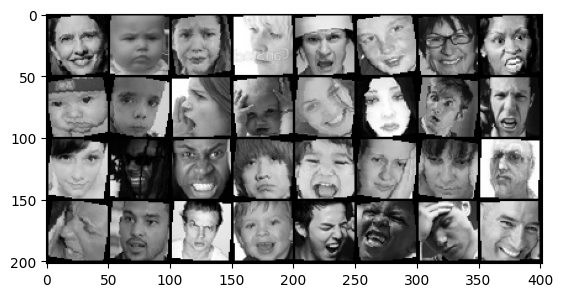

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Define a baseline CNN model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SixLayerCNN(nn.Module):
    def __init__(self):
        super(SixLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(0.25)

        self.conv6 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(2048)
        # Removed the last max pooling operation
        self.dropout6 = nn.Dropout(0.25)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 5)  # Changed the output size to 5

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))
        x = self.dropout5(self.pool5(F.relu(self.bn5(self.conv5(x)))))
        x = self.dropout6(F.relu(self.bn6(self.conv6(x))))  # Removed the last max pooling operation
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
# Assuming that your model is defined and moved to the correct device
model = SixLayerCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("using gpu")
else:
  print("using cpu")

model = model.to(device)

# Print the summary
summary(model, input_size=(1, 48, 48))

using cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
         MaxPool2d-3          [-1, 128, 24, 24]               0
           Dropout-4          [-1, 128, 24, 24]               0
            Conv2d-5          [-1, 256, 24, 24]         295,168
       BatchNorm2d-6          [-1, 256, 24, 24]             512
         MaxPool2d-7          [-1, 256, 12, 12]               0
           Dropout-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 512, 12, 12]       1,180,160
      BatchNorm2d-10          [-1, 512, 12, 12]           1,024
        MaxPool2d-11            [-1, 512, 6, 6]               0
          Dropout-12            [-1, 512, 6, 6]               0
           Conv2d-13           [-1, 1024, 6, 6]       4,719,616
      BatchNorm2d-14         

### Send model to gpu and define loss function, step optimizer, learning rate scheduler

In [ ]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Calculate dataset sizes
dataset_sizes = {
    'Train': len(train_data),
    'Validation': len(validation_data),
    'Test': len(test_data)
}

### Train the model

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=45)
# model = train_model(model, criterion, optimizer, dataloaders, num_epochs=25)

Epoch 0/44
----------
training phase
Train Loss: 1.4770 Acc: 0.3941
eval phase
Validation Loss: 1.2439 Acc: 0.5113

Epoch 1/44
----------
training phase
Train Loss: 1.1934 Acc: 0.5161
eval phase
Validation Loss: 1.0372 Acc: 0.5957

Epoch 2/44
----------
training phase
Train Loss: 1.0729 Acc: 0.5719
eval phase
Validation Loss: 0.9644 Acc: 0.6186

Epoch 3/44
----------
training phase
Train Loss: 1.0202 Acc: 0.5948
eval phase
Validation Loss: 0.9633 Acc: 0.6203

Epoch 4/44
----------
training phase
Train Loss: 0.9785 Acc: 0.6095
eval phase
Validation Loss: 0.9298 Acc: 0.6213

Epoch 5/44
----------
training phase
Train Loss: 0.9513 Acc: 0.6246
eval phase
Validation Loss: 0.9326 Acc: 0.6367

Epoch 6/44
----------
training phase
Train Loss: 0.9170 Acc: 0.6334
eval phase
Validation Loss: 0.9034 Acc: 0.6442

Epoch 7/44
----------
training phase
Train Loss: 0.8395 Acc: 0.6697
eval phase
Validation Loss: 0.8179 Acc: 0.6770

Epoch 8/44
----------
training phase
Train Loss: 0.8015 Acc: 0.6831
eval

### Plot the loss and accuracy values during training for the train and validation sets

In [ ]:
# Plot the history
plot_history(history)

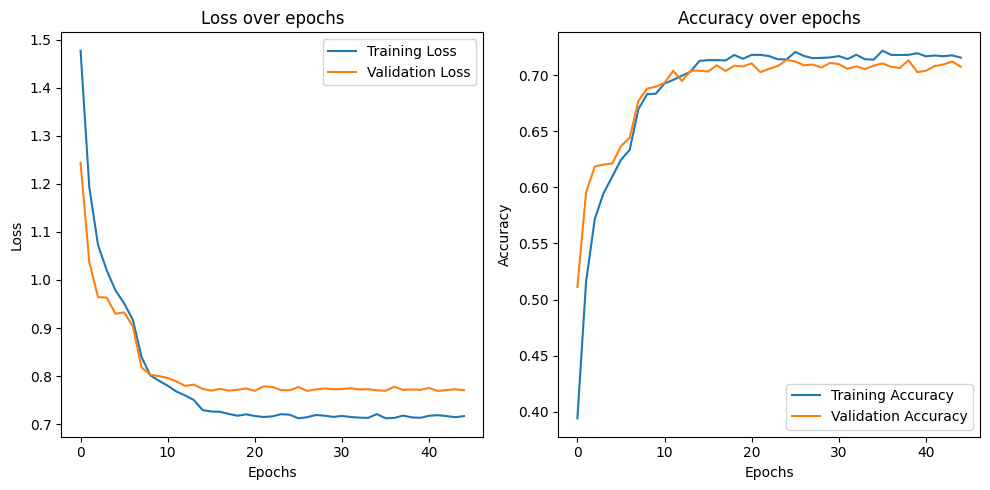

In [2]:
import matplotlib.pyplot as plt

# Define the values for each epoch
train_loss = [1.4770, 1.1934, 1.0729, 1.0202, 0.9785, 0.9513, 0.9170, 0.8395, 0.8015, 0.7902, 0.7800, 0.7679, 0.7597, 0.7502, 0.7293, 0.7263, 0.7257, 0.7213, 0.7175, 0.7204, 0.7170, 0.7149, 0.7162, 0.7208, 0.7196, 0.7121, 0.7145, 0.7191, 0.7176, 0.7151, 0.7171, 0.7149, 0.7135, 0.7131, 0.7209, 0.7123, 0.7129, 0.7179, 0.7141, 0.7132, 0.7175, 0.7187, 0.7168, 0.7145, 0.7167]
val_loss = [1.2439, 1.0372, 0.9644, 0.9633, 0.9298, 0.9326, 0.9034, 0.8179, 0.8028, 0.7999, 0.7960, 0.7888, 0.7796, 0.7823, 0.7733, 0.7699, 0.7734, 0.7698, 0.7715, 0.7742, 0.7694, 0.7787, 0.7774, 0.7709, 0.7705, 0.7772, 0.7692, 0.7723, 0.7742, 0.7726, 0.7731, 0.7748, 0.7722, 0.7728, 0.7704, 0.7695, 0.7778, 0.7714, 0.7722, 0.7715, 0.7752, 0.7691, 0.7710, 0.7726, 0.7706]
train_acc = [0.3941, 0.5161, 0.5719, 0.5948, 0.6095, 0.6246, 0.6334, 0.6697, 0.6831, 0.6835, 0.6926, 0.6958, 0.6995, 0.7032, 0.7127, 0.7134, 0.7134, 0.7131, 0.7180, 0.7146, 0.7181, 0.7181, 0.7170, 0.7142, 0.7140, 0.7207, 0.7171, 0.7152, 0.7154, 0.7158, 0.7170, 0.7144, 0.7182, 0.7142, 0.7138, 0.7218, 0.7181, 0.7180, 0.7181, 0.7196, 0.7168, 0.7175, 0.7169, 0.7177, 0.7156]
val_acc = [0.5113, 0.5957, 0.6186, 0.6203, 0.6213, 0.6367, 0.6442, 0.6770, 0.6880, 0.6897, 0.6931, 0.7040, 0.6948, 0.7040, 0.7040, 0.7033, 0.7088, 0.7037, 0.7085, 0.7078, 0.7105, 0.7027, 0.7057, 0.7081, 0.7136, 0.7122, 0.7088, 0.7095, 0.7068, 0.7109, 0.7098, 0.7057, 0.7078, 0.7054, 0.7085, 0.7105, 0.7075, 0.7064, 0.7133, 0.7027, 0.7040, 0.7081, 0.7095, 0.7122, 0.7075]

# Create a figure
plt.figure(figsize=(10, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Plot performance metrics such as accuracy, precision, recall and f1-score as well as the **Confusion Matrix**

In [ ]:
# Load the state dict previously saved
state_dict = torch.load('/content/drive/MyDrive/Final Project/model_weights/bestmodel_6layer_CNN.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

# Get predictions for the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [ ]:
# Calculate metrics
calculate_metrics(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       491
           1       0.56      0.37      0.45       528
           2       0.87      0.90      0.88       879
           3       0.57      0.71      0.63       594
           4       0.75      0.80      0.77       416

    accuracy                           0.70      2908
   macro avg       0.68      0.68      0.67      2908
weighted avg       0.70      0.70      0.69      2908



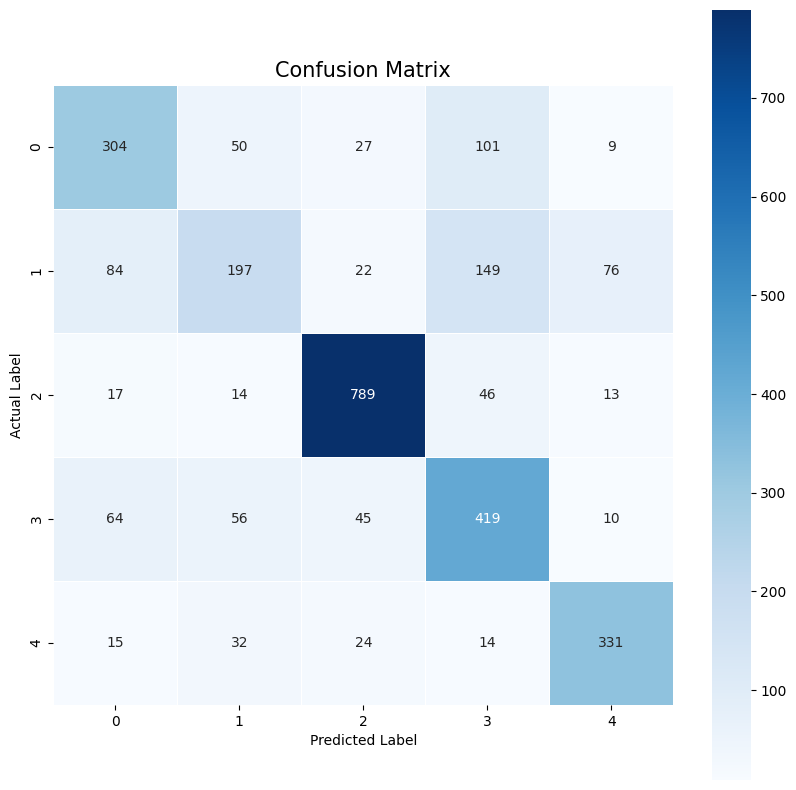

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)